In [111]:
import os
import glob
import pandas as pd

infiles = glob.glob('/home/pm/Documents_sync/PhD/StHelens/gnss_data/*.pos')

positions = {}

for infile in infiles:
    # retrieve station name
    station = os.path.basename(infile).split('.')[0]
    # retrieve GPS position and time dependent height
    df = pd.read_csv(infile, skiprows=36, delim_whitespace=True, usecols=[0,2,12,13, 14, 17])
    # create new date column
    df['date'] = pd.to_datetime(df['*YYYYMMDD'], format='%Y%m%d')
    positions[station] = df

In [112]:
from obspy.signal.filter import highpass
from scipy.signal import detrend
import numpy as np

# Filter dv signals
filtfreq = 1/(2*365.25*24*60*60)
dv_hpf = {}
   
# smooth dU values
for station in positions.keys():
    positions[station]['dU_smoothed'] = positions[station]['dU'].rolling(30).mean()
    # remove outliers
    positions[station]['dU_smoothed'] = positions[station]['dU_smoothed'].mask(np.abs(positions[station]['dU_smoothed']) > 0.1)
    # enter station coordinates
    positions[station]['lat'] = positions[station]['NLat'][0]
    positions[station]['lon'] = positions[station]['Elong'][0]
    # values = positions[station]['dU_smoothed'].values
    # gps_detrend = detrend(values, type='linear')
    # df = 1/(df['date'][1]-df['date'][0]).total_seconds()
    # positions[station]['dU_hpf']= highpass(
    #     gps_detrend, filtfreq, df, corners=4, zerophase=True)

taxis = min([min(p.date) for p in positions.values()]), max([max(p.date) for p in positions.values()])

taxis = pd.date_range(taxis[0], taxis[1], freq='D')

(-0.1, 0.1)

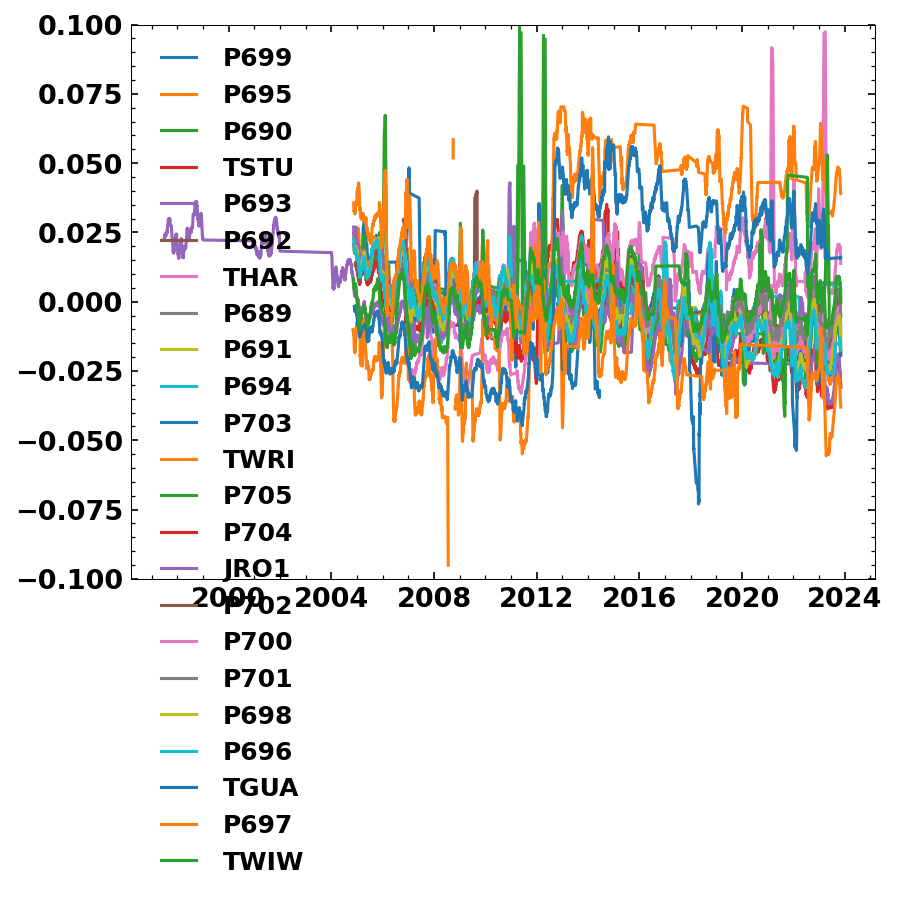

In [113]:
# plot this on a cartesian grid
import matplotlib.pyplot as plt
import numpy as np

# first simply in 1D
for station, df in positions.items():
    plt.plot(df['date'], df['dU_smoothed'], label=station)
plt.legend()
plt.ylim(-0.1, 0.1)

In [114]:
# load dv time-series
import glob
import os

import numpy as np
from matplotlib import pyplot as plt
from obspy import UTCDateTime


corr_len = 3
std_model = 0.002
dv = {}
for freq0, std_model in zip([0.25, 0.5, 1.0], [0.006, 0.002, 0.004]):
    infile = glob.glob(
        f'/home/pm/Documents_sync/PhD/StHelens/spatial/new_gap_handling_ddt_crosssingle_dvfilt_allcc_cl{corr_len}_std{std_model}_largemap/{freq0}-{freq0*2}/dvdt_3D.npz')[0]

    loaded = np.load(infile)

    x = loaded['xaxis']
    y = loaded['yaxis']
    t = loaded['taxis']
    dvdt = loaded['dv']

    start = np.argmin(abs(t - UTCDateTime('2007-06-01').timestamp))
    t = t[start:]
    dv[freq0] = -100*np.nancumsum(dvdt[:, :, start:], axis=-1)
datetimes = [UTCDateTime(tt).datetime for tt in t]



In [115]:
from obspy.signal.filter import highpass
from scipy.signal import detrend
# Filter dv signals
dv_hpf = {}
for freq0 in [0.25, 0.5, 1.0]:
    dv_1d = detrend(dv[freq0])
    df = 1/(datetimes[1]-datetimes[0]).total_seconds()
    filtfreq = 1/(2*365.25*24*60*60)
    dv_hpf[freq0] = highpass(dv_1d, filtfreq, df, corners=4, zerophase=True)

In [116]:
from obspy.geodetics import degrees2kilometers, locations2degrees
import numpy as np

# extents of the dv/v grid
lat = [46.05, 46.36]
lon = [-122.45, -122.03]
res = 1


for station, df in positions.items():
    # compute cartesian coordinates of each station
    df['x'] = -degrees2kilometers(locations2degrees(lat[0], 0, lat[0], df['lon'][0]))
    df['y'] = degrees2kilometers(locations2degrees(0, lon[0], df['lat'][0], lon[0]))
    if np.min(np.abs(df['x'][0] - x)) > res or np.min(np.abs(df['y'][0] - y)) > res:
        print(f'Skipping {station}')
        continue
    

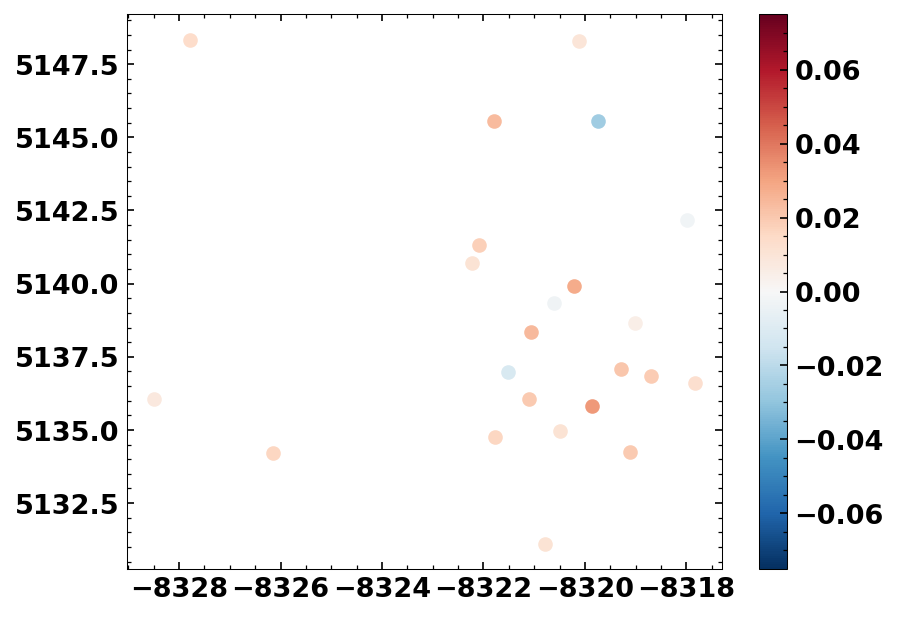

In [117]:
# create a scatter plot of the stations
# with the colour representing the height change
for station, df in positions.items():
    plt.scatter(df['x'].values[0], df['y'].values[0], c=df['dU_smoothed'].values[40], vmin=-0.075, vmax=0.075, cmap='RdBu_r')
plt.colorbar()

## 1D comparison dv/v and GPS motion

/tmp/ipykernel_15475/1398795182.py:8: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  plt.figure()


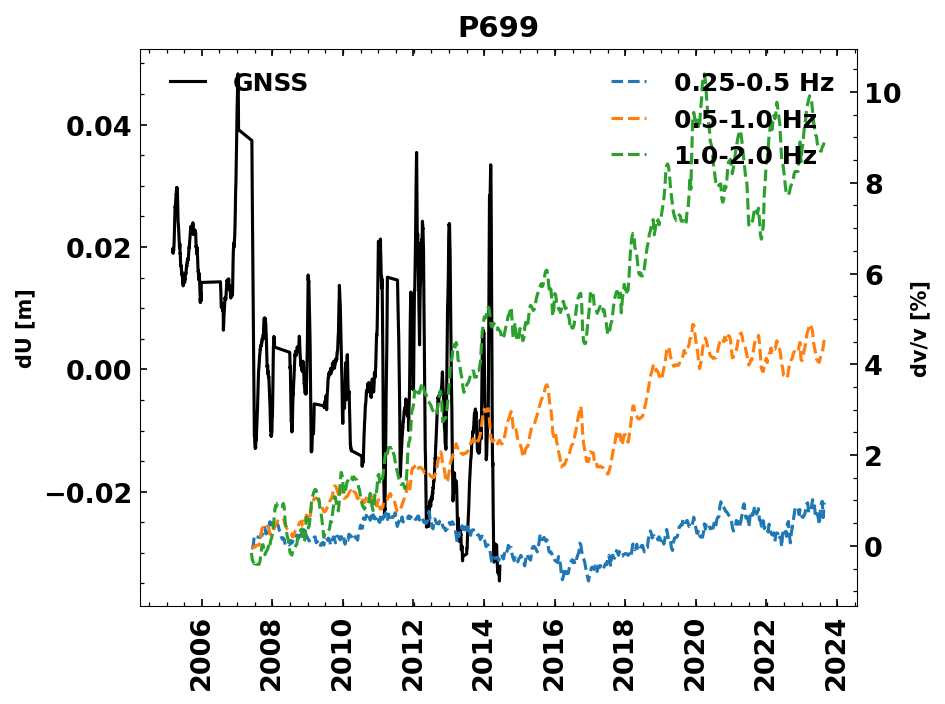

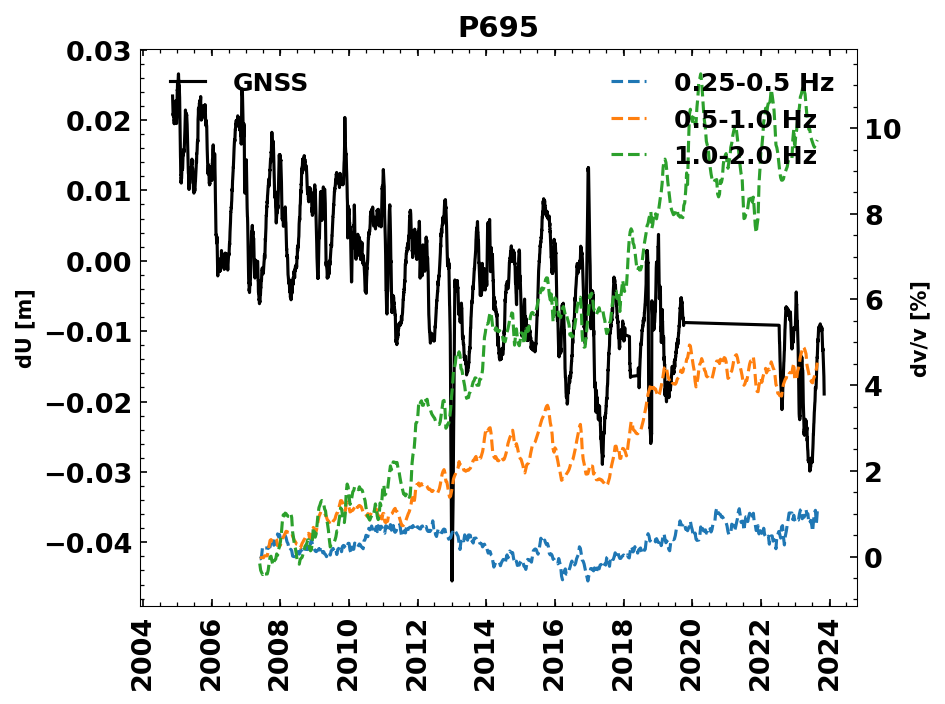

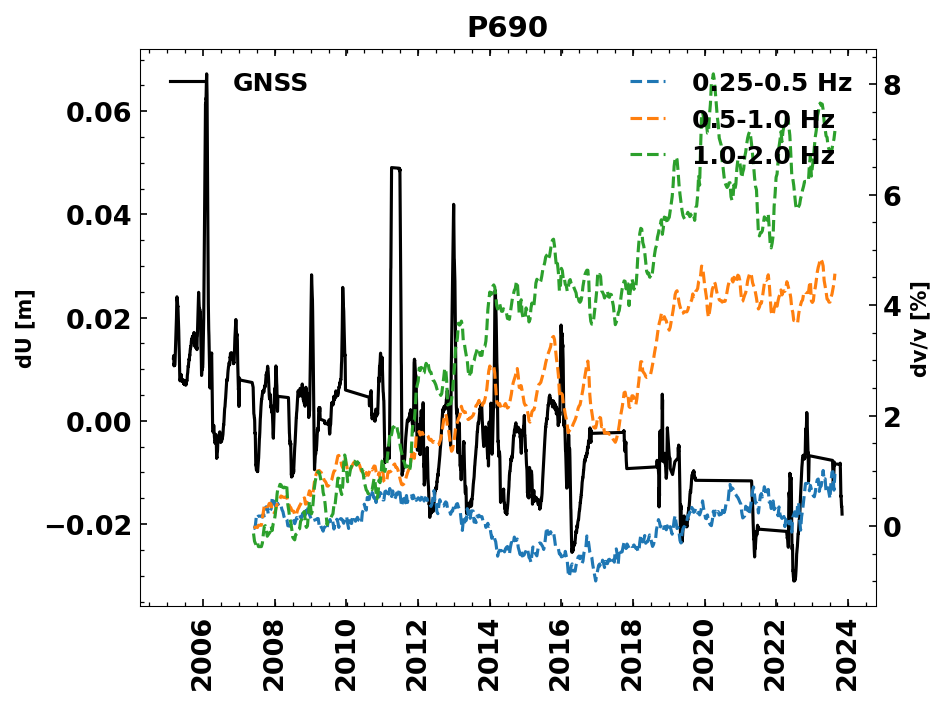

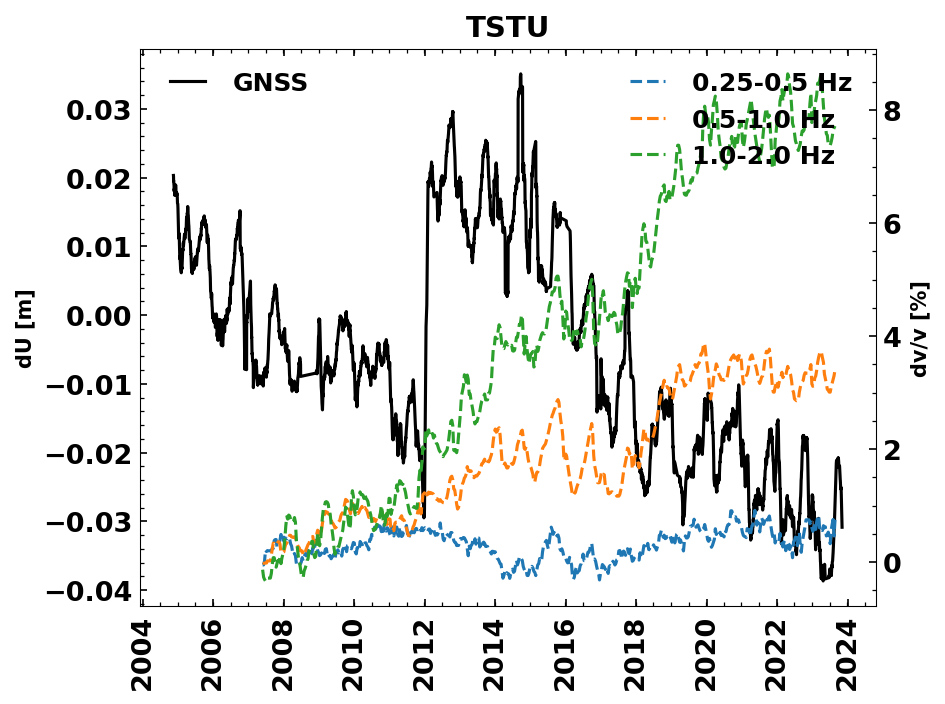

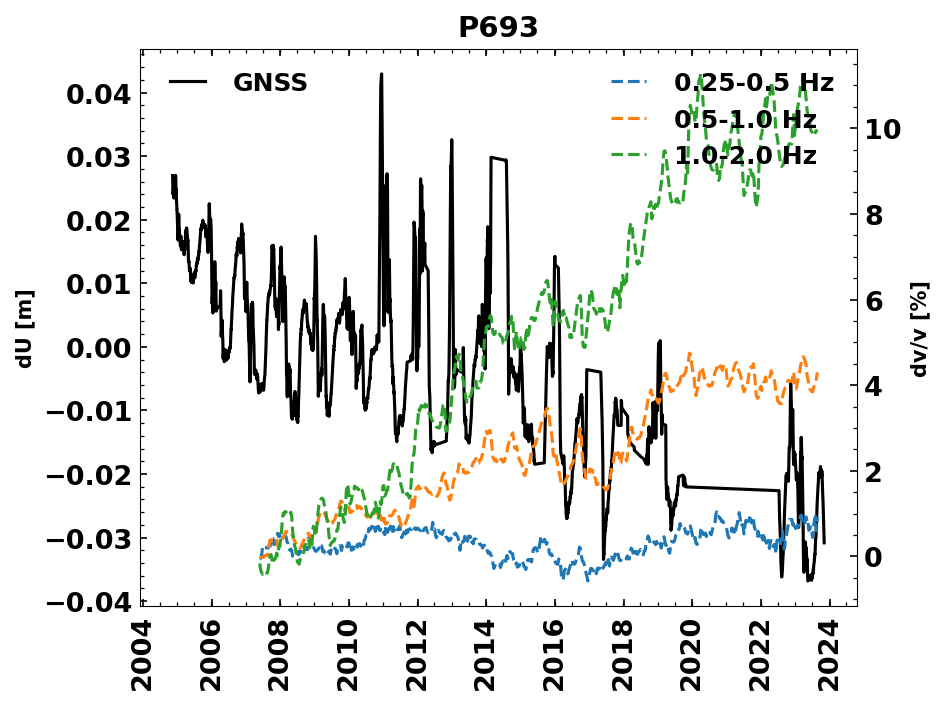

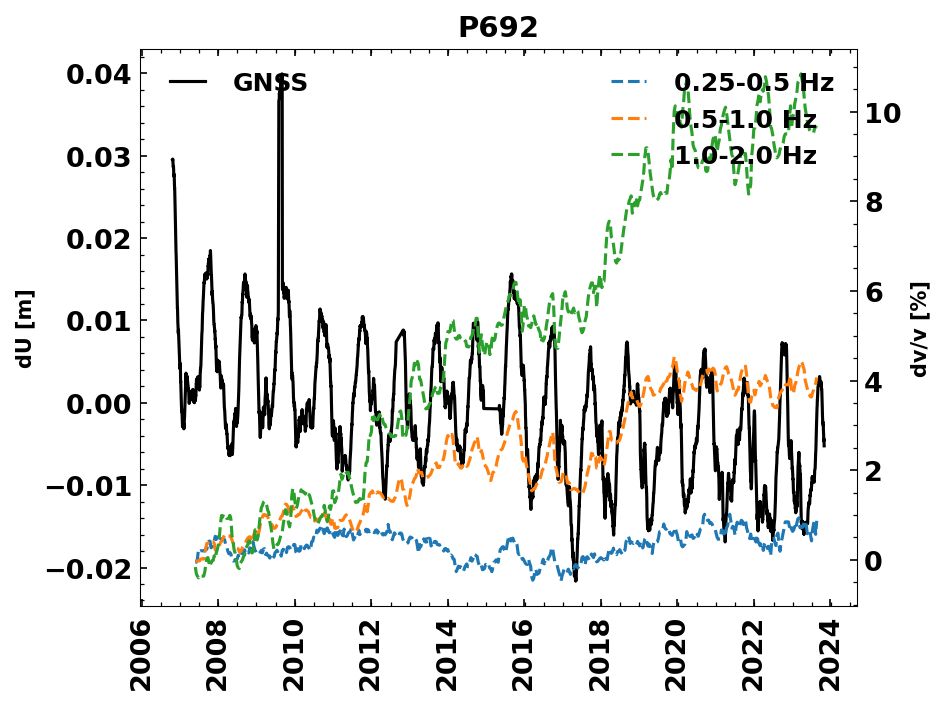

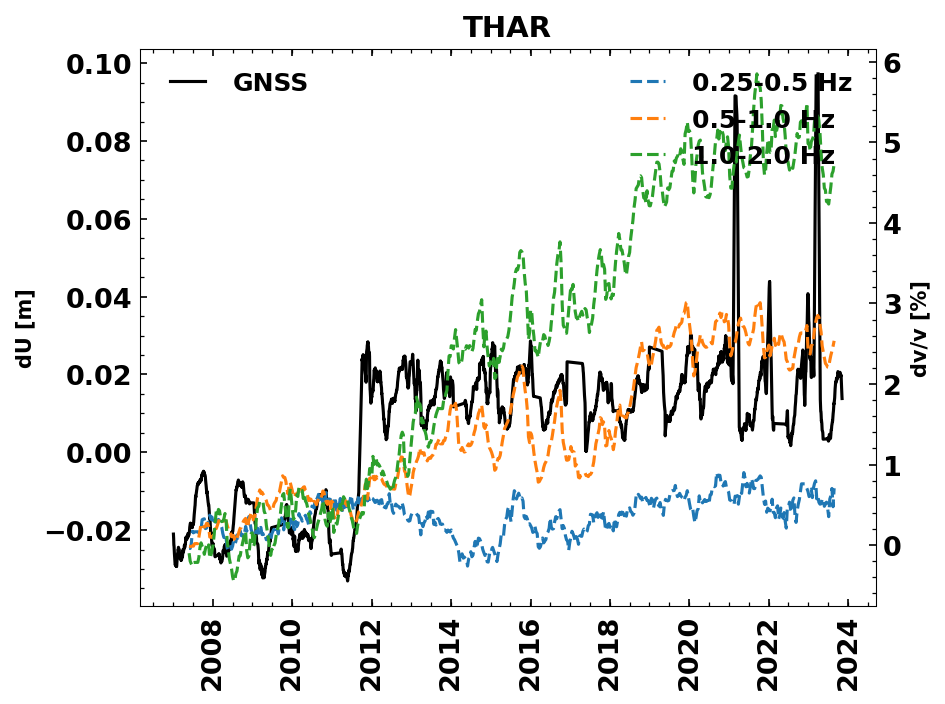

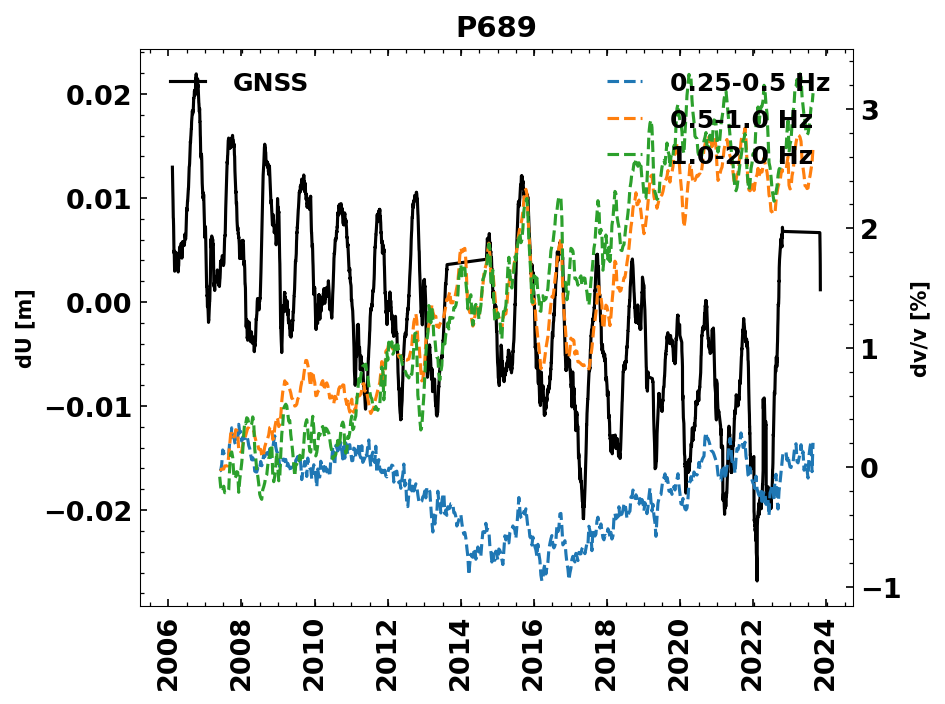

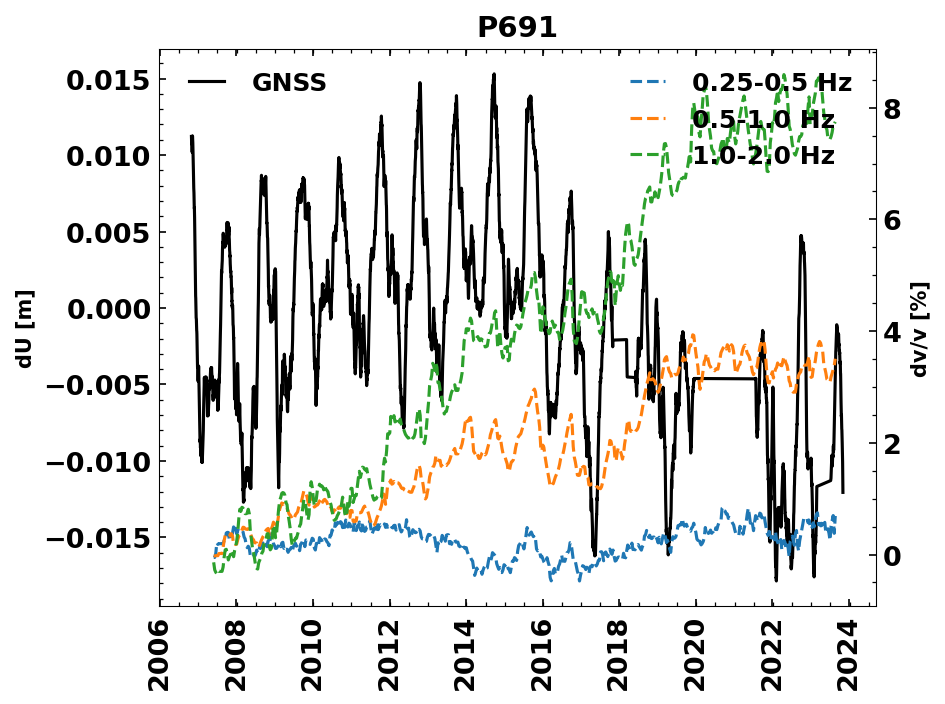

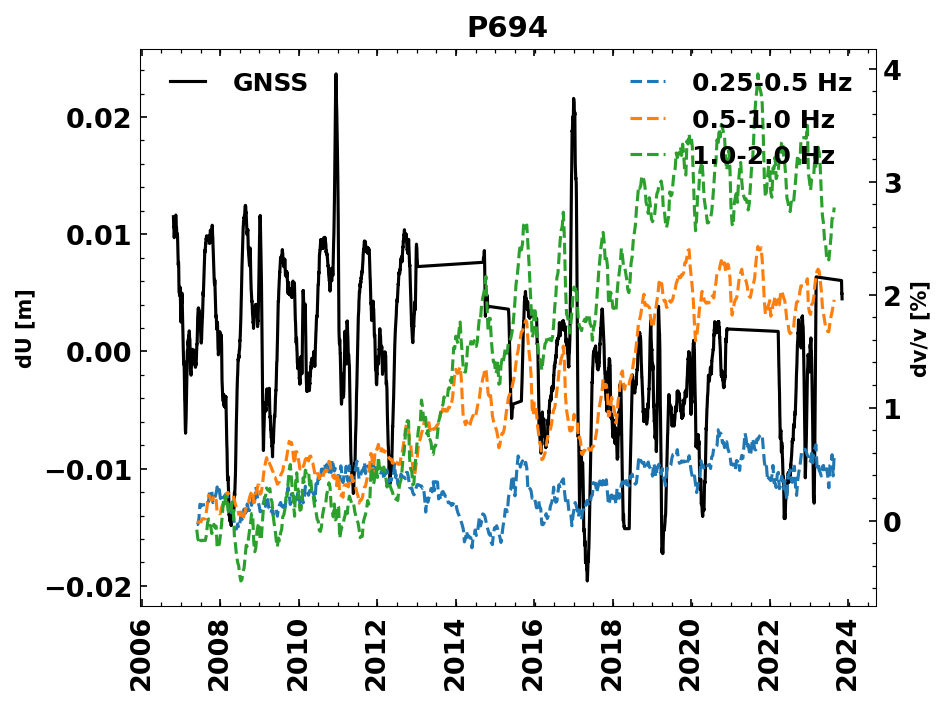

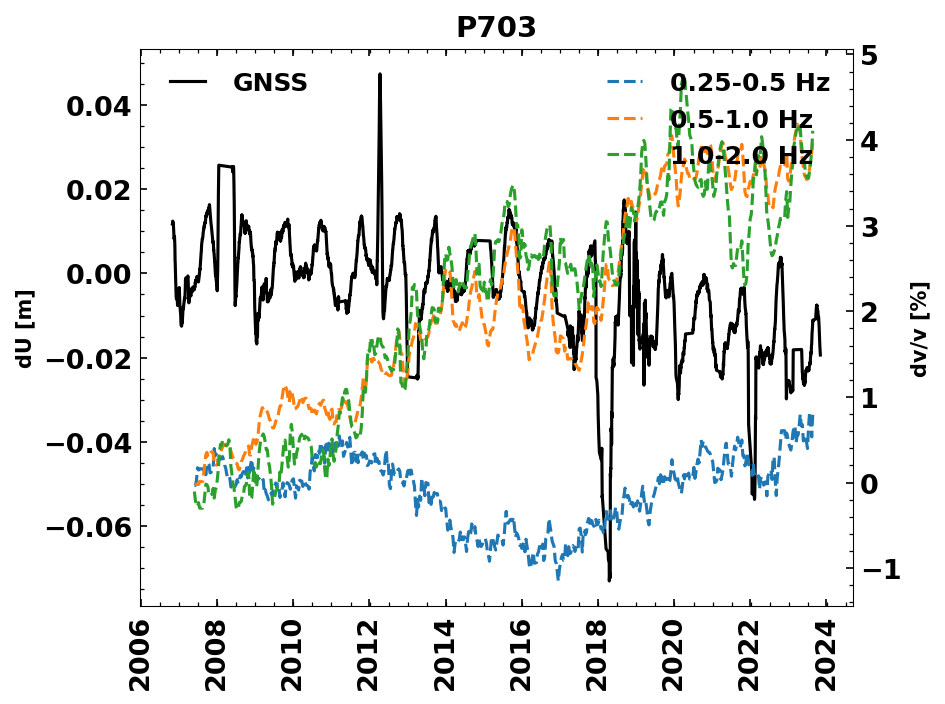

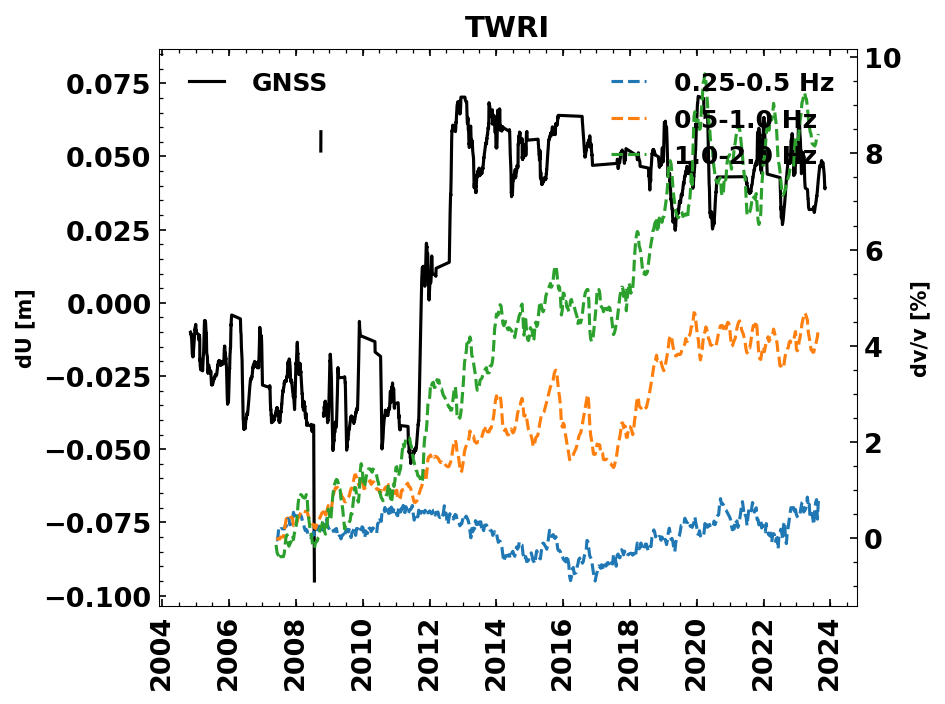

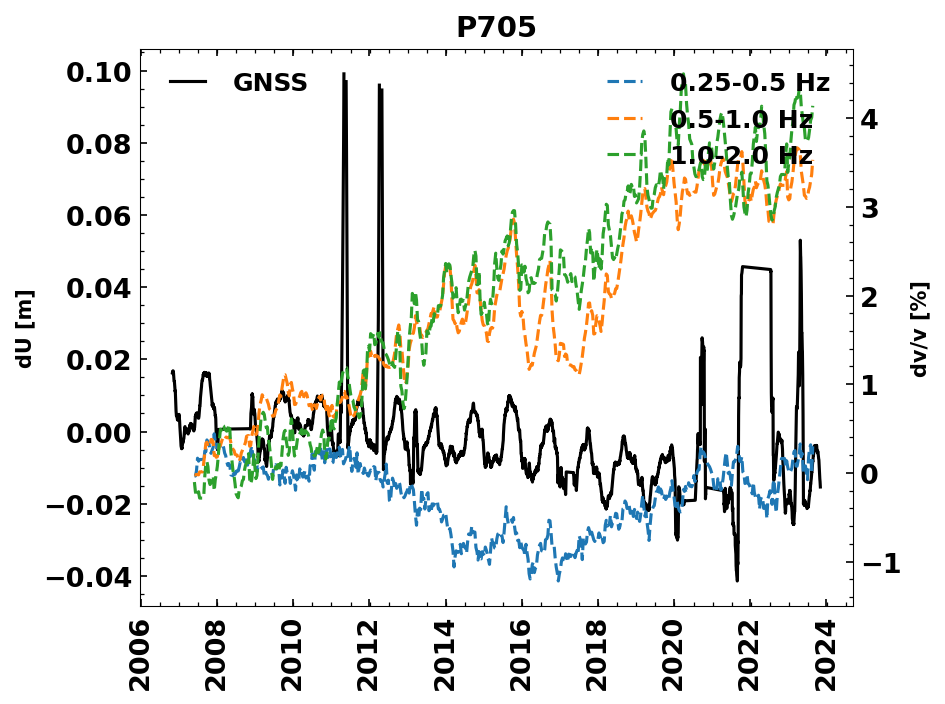

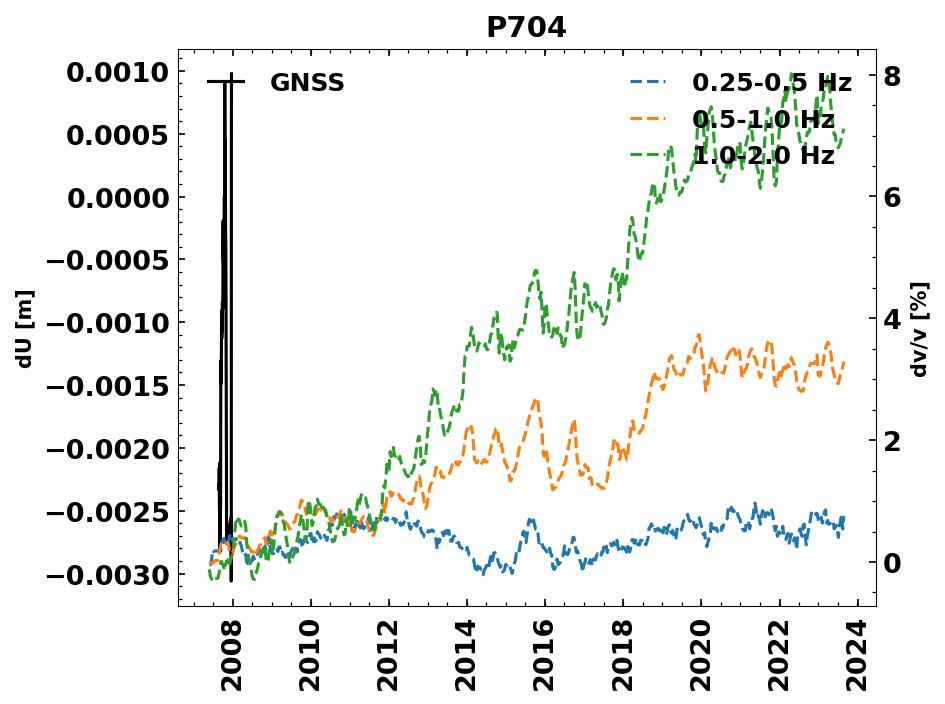

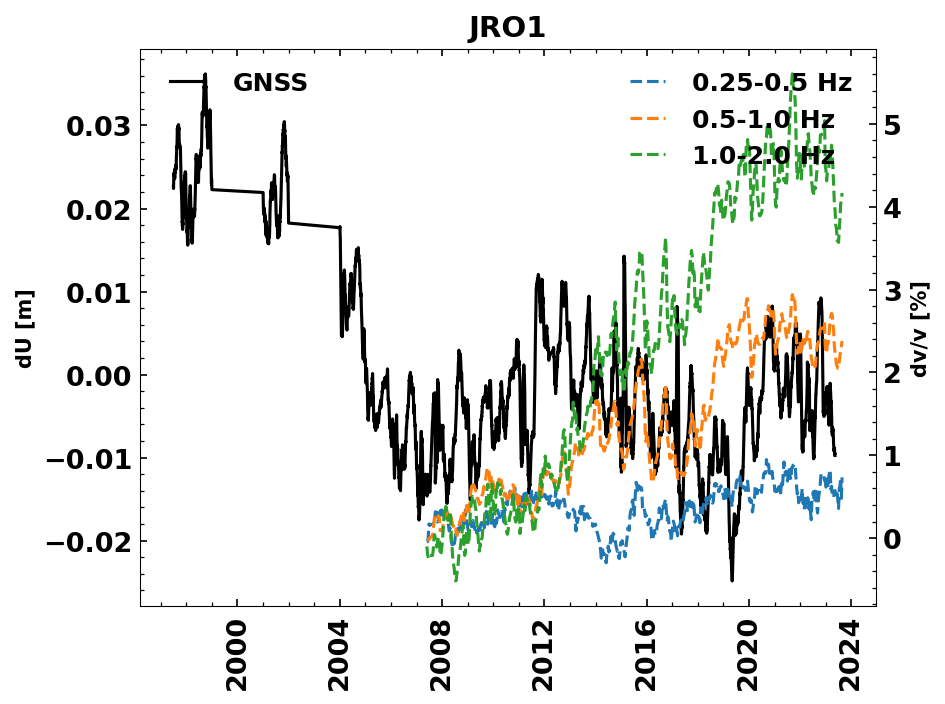

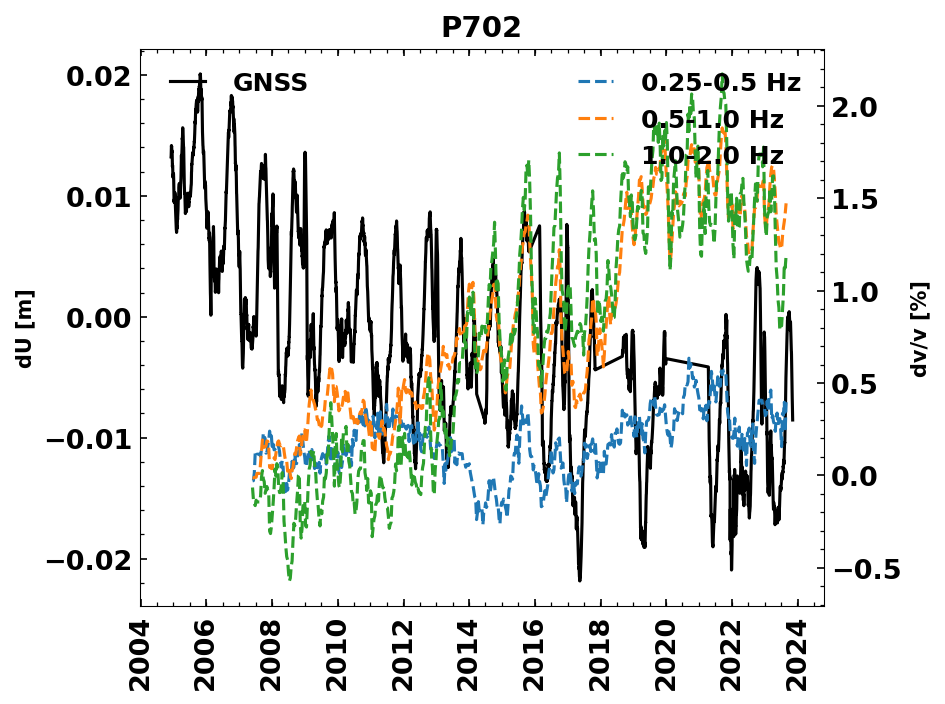

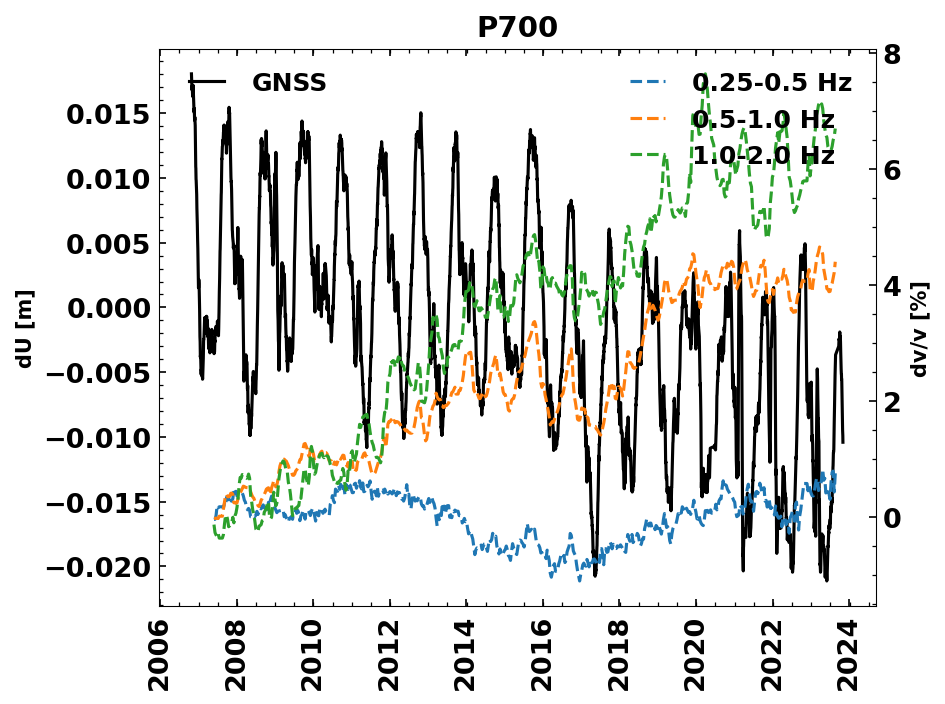

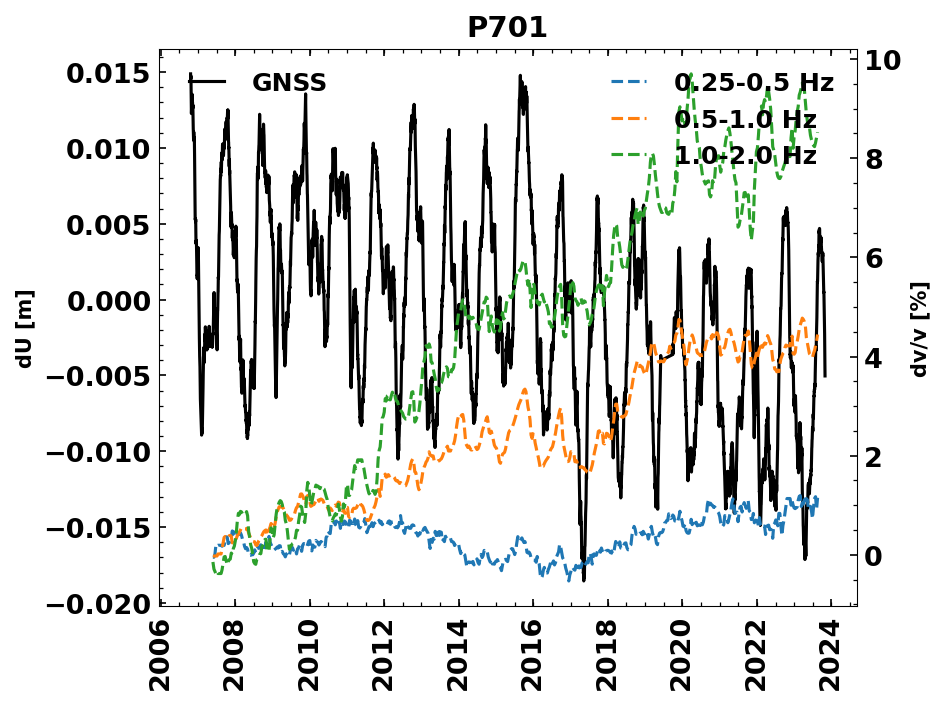

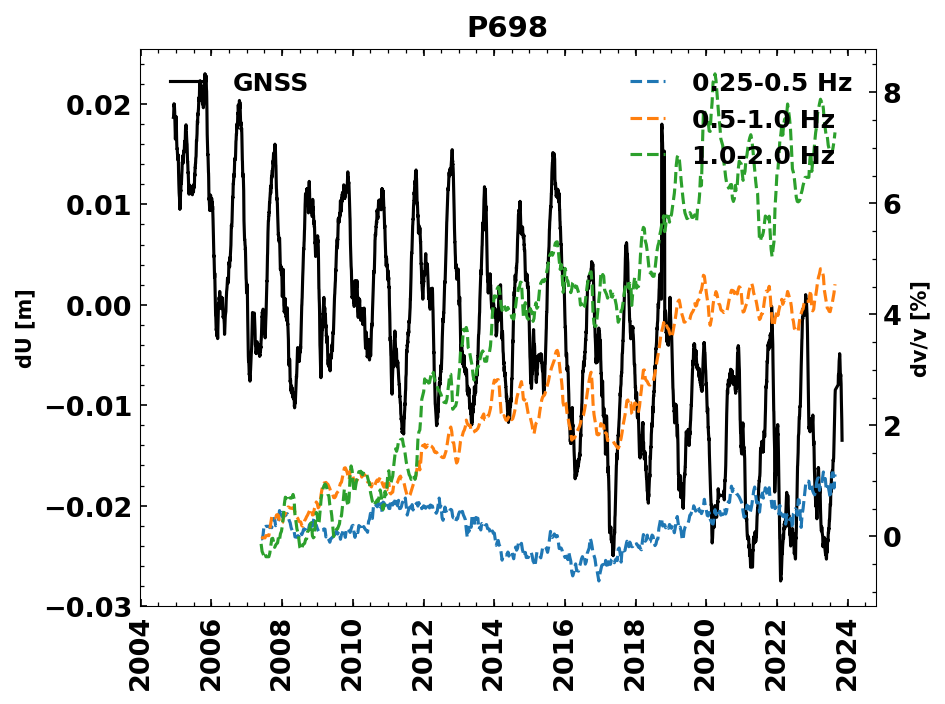

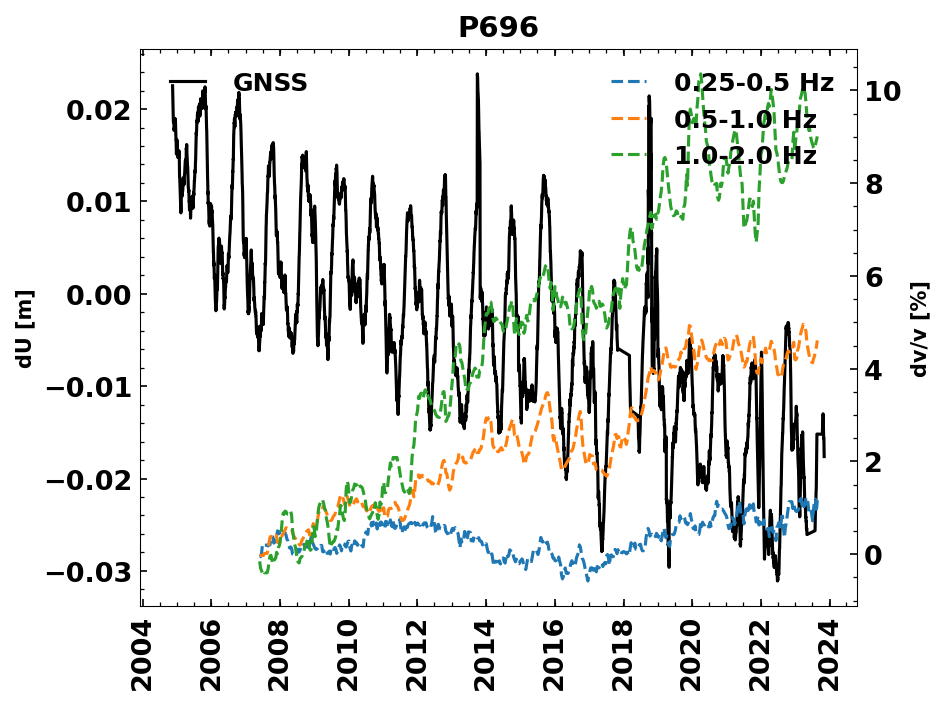

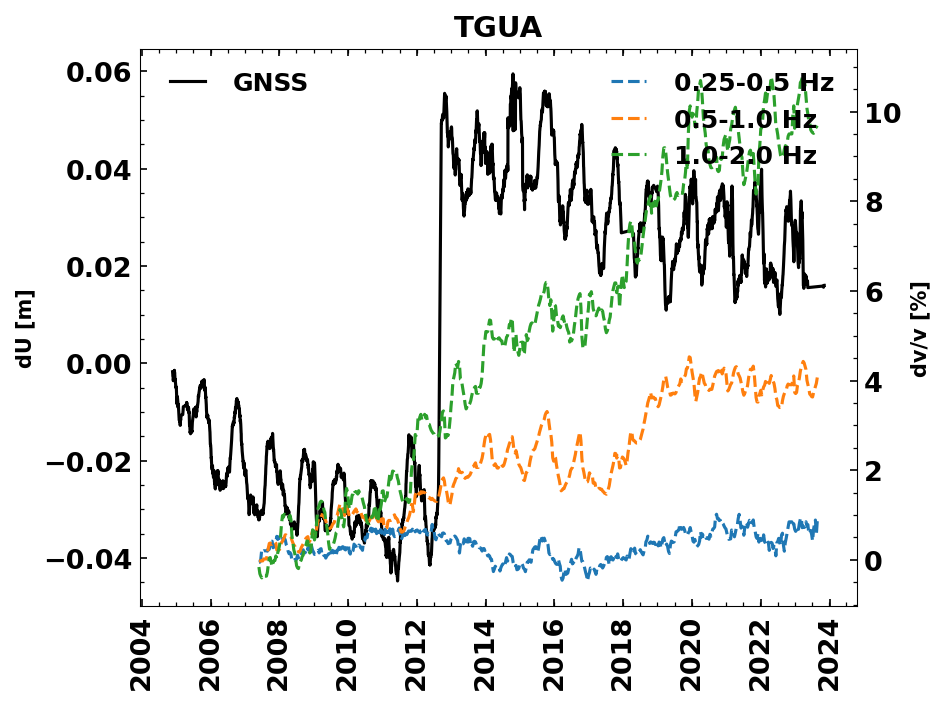

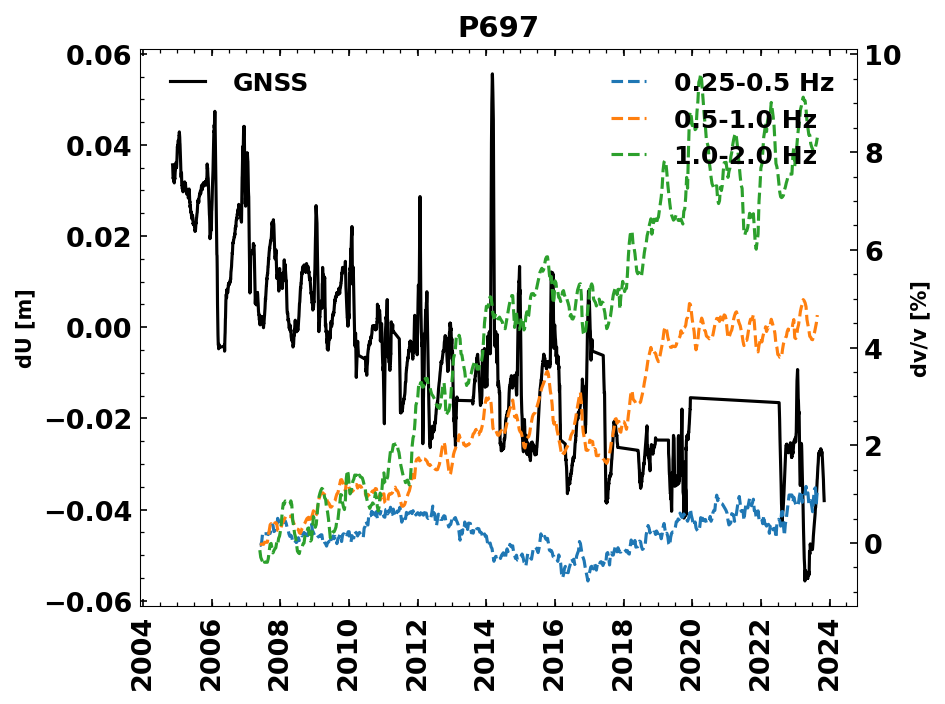

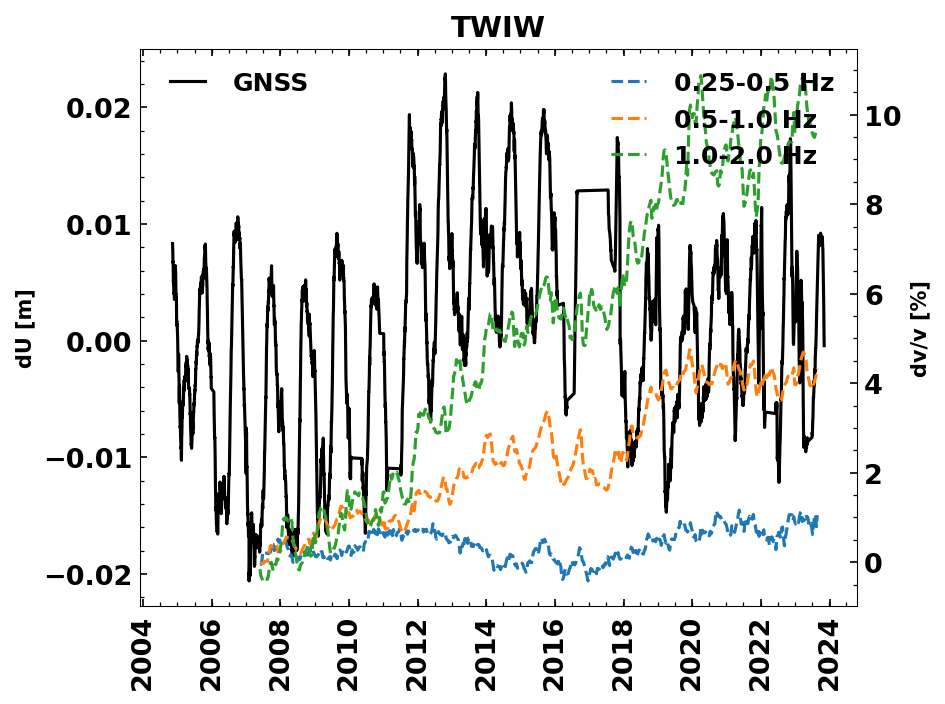

In [118]:
from seismic.plot.plot_utils import set_mpl_params

set_mpl_params()

# find closest grid point of each station and plot against dv/v of this grid point

for station, df in positions.items():
    plt.figure()
    # find closest grid point
    plt.plot(df['date'], df['dU_smoothed'], label='GNSS', color='k')
    plt.ylabel('dU [m]')
    plt.legend()
    # rotate xticklabels by 90 deg
    plt.xticks(rotation=90)
    plt.twinx()
    xind = np.argmin(np.abs(df['x'][0] - x))
    yind = np.argmin(np.abs(df['y'][0] - y))
    # plot dv/v time series
    for freq0 in [0.25, 0.5, 1.0]:
        plt.plot(datetimes, dv[freq0][yind, xind, :], label=f'{freq0}-{freq0*2} Hz', linestyle='--')
    # plot this legend in top right
    plt.legend(loc='upper right')
    plt.ylabel('dv/v [%]')
    plt.title(station)
    
    plt.tight_layout()
